# Import Tlogger data
here I will import the raw tlogger data and save them in an easy to acces format

In [1]:
import pandas as pd
from datetime import timedelta
import pickle
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import math
import numpy as np

from my_func_mvw.functions import find_nearest_date, read_pickle, write_pickle, temp_watertank_func, random_date
from my_func_mvw.fourier_transform_func import resample_data_func, plot_frequency_spectrum, fourier_transform
%load_ext autoreload
%autoreload 2

plot_save=False #True False
masterthesis_save=False

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# Some Version information of the imported packages
# pandas version: 1.2.3
# pickle version: 4.0

Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [2]:
def import_t_logger(path_to_data_Tlogger, filename_Tlogger, data_format="pc_local",channel_name="none"):
    """"""
    if data_format=="CF_Card": #auf Speicherkarte speichern: "stand alone modus"
        df_Tlogger = pd.read_csv(path_to_data_Tlogger + "\\" + filename_Tlogger, sep=";", usecols=[1,2,3,4], names=["Date","Time","Channel1-Watertank","Channel2-Air"])
        DateTime=df_Tlogger["Date"] + " " + df_Tlogger["Time"]
        df_Tlogger.index =pd.to_datetime(DateTime, format=("%d.%m.%y  %H:%M:%S"))
        df_Tlogger.index.names = ['Date']
        df_Tlogger = df_Tlogger.drop(df_Tlogger.columns[0:2],axis=1) # drop the two columns which are now used for index

    if data_format == "pc_local": #direkt auf pc speichern
        #channel 2 wird im moment hier nicht eingeladen, da das datum sich teilweise um wenige sekunden unterscheided
        #müsste beide indices noch anpassen so das sie zusammenpassen
        def import_helper(filename,channel_name):
            df_Tlogger = pd.read_csv(
                filename, sep="\s+|\t| ", usecols=[0,1,2],
                names=["Date","Time",channel_name], engine="python")
            DateTime=df_Tlogger["Date"] + " " + df_Tlogger["Time"]
            df_Tlogger.index =pd.to_datetime(DateTime, format=("%d.%m.%Y %H:%M:%S"))
            df_Tlogger.index.names = ['Date']
            df_Tlogger = df_Tlogger.drop(df_Tlogger.columns[0:2],axis=1) # drop the two columns which are now used for index
            return df_Tlogger

        df_Tlogger = import_helper(path_to_data_Tlogger + "\\" + filename_Tlogger,channel_name)
        
    return df_Tlogger

In [3]:
# Load data T-logger
path_to_data_Tlogger = r"..\Alsdorf\Daten\T-logger"
# PT sensors
# channel1 in watertank PT100
# channel2 air PT1000
filename_Tlogger_0 = "20210608\_adc_START_07.06.2021-12_11_40_daten.txt" 
filename_Tlogger_1 = "20210702\_adc_START_08.06.2021-13_21_47_daten.txt"
filename_Tlogger_2 = "20210708\_adc_START_02.07.2021-12_36_14_daten.txt"
filenames_CFCard = [filename_Tlogger_0,filename_Tlogger_1,filename_Tlogger_2]
# new dataformat
filename_Tlogger_3 = "20210722\kanal_1.txt"
filename_Tlogger_4 = "20210727\kanal_1.txt"
filename_Tlogger_5 = "20210802\kanal_1.txt"
filenames_pc = [filename_Tlogger_3,filename_Tlogger_4,filename_Tlogger_5]

df_Tlogger_PT100_part={}
for filename in filenames_CFCard:
    df_Tlogger_PT100_part[filename] = import_t_logger(path_to_data_Tlogger, filename, data_format="CF_Card")
for filename in filenames_pc:
    df_Tlogger_PT100_part[filename] = import_t_logger(path_to_data_Tlogger, filename, channel_name = "Channel1-Watertank")

# concat all dataframes
df_Tlogger_PT100 = df_Tlogger_PT100_part[filenames_CFCard[0]]
for dataframe in list(df_Tlogger_PT100_part.keys())[1:]:
    df_Tlogger_PT100 = pd.concat([df_Tlogger_PT100,df_Tlogger_PT100_part[dataframe]])
df_Tlogger_PT100.sort_index(inplace=True)

df_Tlogger_PT100

,Channel1-Watertank,Channel2-Air
Date,,
2021-06-07 12:12:40,24.948476,25.819904
2021-06-07 12:13:40,25.026853,25.443956
2021-06-07 12:14:40,24.888809,25.165027
2021-06-07 12:15:40,25.011371,24.926351
2021-06-07 12:16:40,25.014596,24.753213
...,...,...
2021-08-02 11:34:54,22.817576,NaN
2021-08-02 11:37:54,22.811149,NaN
2021-08-02 11:40:54,22.811149,NaN


In [4]:
# PT1000 sensors
# two new sensors, both are now in watertank, I create new dataframe
######## Add new, when downloading new data from t_logger###################
filename_Tlogger_5_1 = "20210809\kanal_1.txt"
filename_Tlogger_5_2 = "20210809\kanal_2.txt"
filename_Tlogger_6_1 = "20210917\kanal_1.txt"
filename_Tlogger_6_2 = "20210917\kanal_2.txt"
filename_Tlogger_7_1 = "20211104\kanal_1.txt"
filename_Tlogger_7_2 = "20211104\kanal_2.txt"
filenames_pc_1 = [filename_Tlogger_5_1,filename_Tlogger_6_1,filename_Tlogger_7_1]
filenames_pc_2 = [filename_Tlogger_5_2,filename_Tlogger_6_2,filename_Tlogger_7_2]
##########################################################################

#import data
df_Tlogger_PT1000_part={}
for filename in filenames_pc_1:
    df_Tlogger_PT1000_part[filename] = import_t_logger(path_to_data_Tlogger, filename, channel_name = "Channel1_PT1000")
for filename in filenames_pc_2:
    df_Tlogger_PT1000_part[filename] = import_t_logger(path_to_data_Tlogger, filename, channel_name = "Channel2_PT1000")

In [5]:
# Only relevant for data_format = "pc_local"
# these chanels can have different indexes, with a very small difference
# I will make them more simialr to avoid a lot of nan numbers in the dataframe

count_files=0 # for finding the corresponding data of kanal 1
for part_name_kanal2 in filenames_pc_2:
    new_index = []
    counter = 0
    for i in range(len(df_Tlogger_PT1000_part[part_name_kanal2].index)): # go through all dates
        date = df_Tlogger_PT1000_part[part_name_kanal2].index[i]
        # find date_name in other channel, which is closest to the date of channel 2
        date_name, date_iloc = find_nearest_date(date, df_Tlogger_PT1000_part[filenames_pc_1[count_files]].index)
        timediff = pd.to_datetime(date_name) - date
        if timediff < timedelta(seconds = 0): # make timediff positive, if its negative
            timediff = timediff * -1

        seconds=60
        if timediff < timedelta(seconds = seconds):
            # temp_val = df_Tlogger_PT1000_part['20210809\\kanal_2.txt'].values[i]
            # dataframe = pd.DataFrame(columns=["Channel2_PT1000"], index=[pd.to_datetime(date_name)])
            # dataframe["Channel2_PT1000"] = temp_val
            # dataframe.index.names = ["Date"]
            # df_Tlogger_PT1000_part['20210809\\kanal_2.txt']["Channel2_PT1000"][i] = dataframe

            new_index.append(pd.to_datetime(date_name))
        else:
            new_index.append(pd.to_datetime(date))
            counter += 1
    
    df_Tlogger_PT1000_part[part_name_kanal2].index = new_index
    df_Tlogger_PT1000_part[part_name_kanal2].index.name="Date"

    if counter > 0:
        print(f"timediff larger than {seconds}s {counter} times")
    
    count_files+=1

timediff larger than 60s 4 times


In [6]:
#concat all data
df_Tlogger_PT1000_segments={}
for export_segment in range(len(filenames_pc_1)):
    df_Tlogger_PT1000_segments[export_segment]=pd.concat([df_Tlogger_PT1000_part[filenames_pc_1[export_segment]],df_Tlogger_PT1000_part[filenames_pc_2[export_segment]]], axis=1)

df_Tlogger_PT1000=df_Tlogger_PT1000_segments[list(df_Tlogger_PT1000_segments.keys())[0]]
for export_segment in list(df_Tlogger_PT1000_segments.keys())[1:]:
    df_Tlogger_PT1000=pd.concat([df_Tlogger_PT1000,df_Tlogger_PT1000_segments[export_segment]])

df_Tlogger_PT1000.sort_index(inplace=True)
df_Tlogger_PT1000

,Channel1_PT1000,Channel2_PT1000
Date,,
2021-08-04 11:18:42,20.453140,20.464840
2021-08-04 11:21:42,20.446965,20.455567
2021-08-04 11:24:42,20.448508,20.440113
2021-08-04 11:27:42,20.426124,20.448613
2021-08-04 11:30:42,20.433071,20.457113
...,...,...
2021-10-06 10:49:47,17.687406,17.510337
2021-10-06 10:52:47,17.667393,17.511107
2021-10-06 10:55:47,17.690485,17.513419


In [7]:
# data from solexperts, which can be used for my calibration
# import solexperts t_logger
path_to_solexperts = path_to_data_Tlogger + r"\..\Solexperts_EGRT"
filename = "\wagoTemperatur_korigiert.txt"
tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
tlogger_sol.columns.names = ["Dates"]
tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
tlogger_sol.index=["Watertank"]
tlogger_sol.index.names = [""]
tlogger_sol = tlogger_sol.T
tlogger_sol.columns = ["Channel1-Watertank"] # name is does not fit to this data, just for concat woth my other dataframe

In [8]:
# Übergangslösung bis PT1000 mehr Daten hat
# correct old data
df_Tlogger_PT100["Channel1-Watertank"] = df_Tlogger_PT100["Channel1-Watertank"] - 1.5

# add PT1000 data
df_Tlogger_übergang = pd.DataFrame(columns=["Channel1-Watertank","Channel2-Air"]) #,"Channel1_rolling_mean"
df_Tlogger_übergang["Channel1-Watertank"] = df_Tlogger_PT1000["Channel1_PT1000"]
#df_Tlogger_übergang["Channel1_rolling_mean"] = df_Tlogger_PT1000["Channel1-PT1000_rolling_mean"]
df_Tlogger_PT100 = pd.concat([df_Tlogger_PT100, df_Tlogger_übergang]).sort_index()

# add also some data from solexperts, which can be used for my calibration
    # --> outside heating and cooling phase
    # drop the data of our dataframe before concat, so nothing is doubled
df_Tlogger_all = pd.concat([df_Tlogger_PT100.drop(df_Tlogger_PT100[16160:16160+410].index), tlogger_sol[6000:]]).sort_index()

In [9]:
# Add nan values in data gaps

# find data gaps
def add_nan_val_in_datagaps(df_Tlogger):
    """"""
    diff = df_Tlogger.index[1:] - df_Tlogger.index[:-1]

    index_datagaps=[]
    for i in range(len(diff)):
        bo = diff[i] > timedelta(minutes=10)
        if bo == True:
            index_datagaps.append(i)
            #print(i)#;print(diff[i]) #i gibt einem die position des Datums ab welchem danach die Lücke ist

    # add values in data gaps
    n_appended_values = 0 # count the number of values I add to the dataframe
    for index in index_datagaps:
        index_corrected = index + n_appended_values # the dataframe gets new values in other date gaps before this one
        # number of dates with nan, that will be added behin the index position
        # round down and minus 1 to be sure I dont add a nan behind an existing date
        n_nan_dates = math.floor(diff[index] / timedelta(minutes=3)) - 1
        n_appended_values += n_nan_dates
        list_nan = [np.nan] * n_nan_dates # list of nan

        # add nan's in data gaps, by creating new datapoints with a timedifference of 3 min.
        # create dataframe which contains the dates and nan values
        new_val = pd.DataFrame({df_Tlogger.columns[0]: list_nan, df_Tlogger.columns[1]: list_nan}) #, df_Tlogger.columns[2]: list_nan}
        new_val.index = [df_Tlogger.index[index_corrected] + timedelta(minutes=x*3) for x in range(1,n_nan_dates+1)]

        # add nan values to Tlogger dataframe and sort it
        df_Tlogger = df_Tlogger.append(new_val).sort_index()
    print(f"{n_appended_values} dates with nan have been added")


    # Check if everything worked correct
    # find data gaps
    diff = df_Tlogger.index[1:] - df_Tlogger.index[:-1]
    for i in range(len(diff)):
        bo = diff[i] > timedelta(minutes=10)
        if bo == True:
            print("There are still some indexes missing:")
            print(i);print(diff[i]);print() #i gibt einem die position des Datums ab welchem danach die Lücke ist
    
    return df_Tlogger

print("df_PT100")
df_Tlogger_PT100 = add_nan_val_in_datagaps(df_Tlogger_PT100)
print("df_PT1000")
df_Tlogger_PT1000 = add_nan_val_in_datagaps(df_Tlogger_PT1000)
print("df_Tlogger_all")
df_Tlogger_all = add_nan_val_in_datagaps(df_Tlogger_all)

df_PT100
7290 dates with nan have been added
df_PT1000
0 dates with nan have been added
df_Tlogger_all
5914 dates with nan have been added


In [10]:
#Simple Moving Avearage
#https://towardsdatascience.com/moving-averages-in-python-16170e20f6c nice explanation
df_Tlogger_PT100["Channel1_rolling_mean"]=df_Tlogger_PT100["Channel1-Watertank"].rolling(5,min_periods=3, center = True).mean() # 15 min window time

df_Tlogger_PT1000["Channel1-PT1000_rolling_mean"]=df_Tlogger_PT1000["Channel1_PT1000"].rolling(5,min_periods=3, center = True).mean() # 15 min window time

df_Tlogger_all["Channel1_rolling_mean"]=df_Tlogger_PT100["Channel1-Watertank"].rolling(5,min_periods=3, center = True).mean() # 15 min window time

In [11]:
# round data to significant position
df_Tlogger_PT100 = round(df_Tlogger_PT100,1)
df_Tlogger_PT1000 = round(df_Tlogger_PT1000,1)
df_Tlogger_all = round(df_Tlogger_all,1)

In [12]:
# save tlogger data

# df_Tlogger_PT100.to_csv(path_to_data_Tlogger + r"\processed\Tlogger_PT100_outdated.csv")
# write_pickle(path_to_data_Tlogger + r"\processed\Tlogger_PT100_outdated",df_Tlogger_PT100)

df_Tlogger_PT1000.to_csv(path_to_data_Tlogger + r"\processed\Tlogger_PT1000.csv")
write_pickle(path_to_data_Tlogger + r"\processed\Tlogger_PT1000",df_Tlogger_PT1000)

df_Tlogger_all.to_csv(path_to_data_Tlogger + r"\processed\Tlogger_all.csv")
write_pickle(path_to_data_Tlogger + r"\processed\Tlogger_all" ,df_Tlogger_all)

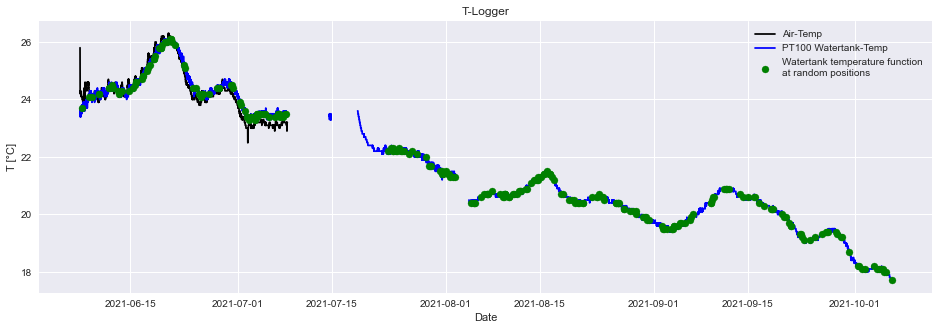

In [14]:
# Plot T-Logger data
number_test_watertank_function = 300 #Input
plot_function_check = True #Input
plot_air = True #Input

watertank_T_range_min = df_Tlogger_all["Channel1-Watertank"].dropna().index.min()
watertank_T_range_max = df_Tlogger_all["Channel1-Watertank"].dropna().index.max()

# generate random dates in range of T-Logger dates
random_date_list=[]
for number in range(number_test_watertank_function):
    r_date = random_date(watertank_T_range_min,watertank_T_range_max)
    random_date_list.append(r_date)

# Plot function and data, to see if it is good
y=df_Tlogger_all["Channel1-Watertank"].values
x_dates=df_Tlogger_all["Channel1-Watertank"].index
T_avearage=temp_watertank_func(random_date_list, df_Tlogger_all)
# I could also plot it like this, but this does not show, that my function works
#plt.plot(df_Tlogger_all["Channel1-rolling_mean"].index,df_Tlogger_all["Channel1-rolling_mean"].values,label="Watertank rolling mean")
plt.figure(figsize=(16,5))
if plot_air:
    plt.plot(df_Tlogger_all["Channel2-Air"].index,df_Tlogger_all["Channel2-Air"].values,label="Air-Temp",color="black",zorder=8)
plt.plot(x_dates,y,label="PT-sensor Watertank-Temp",color="blue",zorder=9)
if plot_function_check:
    plt.scatter(random_date_list,T_avearage,label="Watertank temperature function\nat random positions",color="green",zorder=10)

# y=df_Tlogger_all["Channel1_PT1000"].dropna().values
# x_dates=df_Tlogger_all["Channel1_PT1000"].dropna().index
# plt.plot(x_dates,y,label="PT1000-1 Watertank-Temp",color="purple")

# y=df_Tlogger_all["Channel2_PT1000"].dropna().values
# x_dates=df_Tlogger_all["Channel2_PT1000"].dropna().index
# plt.plot(x_dates,y,label="PT1000-2 Watertank-Temp",color="blue")

# y=df_Tlogger_all["Channel1-rolling_mean"].values
# x_dates=df_Tlogger_all["Channel1-rolling_mean"].index
# plt.scatter(x_dates,y,label="Watertank-Temp rolling_mean",color="red",zorder=10)

plt.ylabel("T [°C]")
plt.xlabel("Date")
plt.title("T-Logger")
plt.legend()
plt.show()
#Wassertank am 07.06.2021 aufgefüllt, mit kälteren Wasser

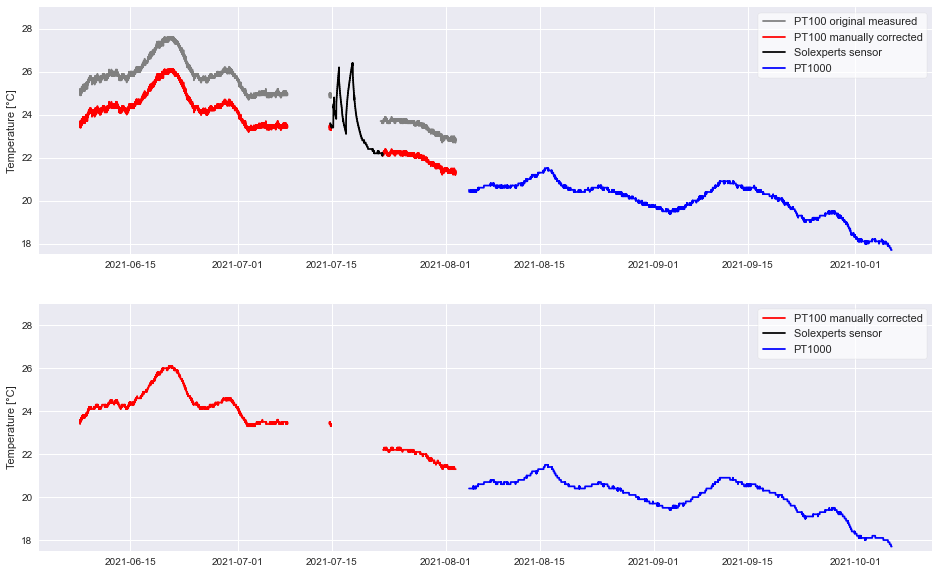

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(16,10))
ymin=17.5; ymax=29
dftlog=df_Tlogger_all["Channel1-Watertank"]
dftlog_rolling=df_Tlogger_all["Channel1_rolling_mean"]
dftlog_sol=tlogger_sol["Channel1-Watertank"][100:] #skip first ones because they are very high
# are not perfectly chosen, but due to data gaps its looks ok
border_temp1=20000
border_temp2=26000
border_temp3=32500

#axs[0].set_title("Water Tank Temperature", fontsize="13")
axs[0].plot(dftlog[:border_temp1].index,dftlog[:border_temp1].values + 1.5,color="grey", label="PT100 original measured")
axs[0].plot(dftlog[:border_temp1].index,dftlog[:border_temp1].values,color="red", label="PT100 manually corrected")

axs[0].plot(dftlog[border_temp2:border_temp3].index,dftlog[border_temp2:border_temp3].values +1.5,color="grey")
axs[0].plot(dftlog[border_temp2:border_temp3].index,dftlog[border_temp2:border_temp3].values,color="red")

axs[0].plot(dftlog_sol.index,dftlog_sol.values, color="black", label="Solexperts sensor")

axs[0].plot(dftlog[border_temp3:].index,dftlog[border_temp3:].values,color="blue", label="PT1000")


#axs[1].set_title("Data Used For Calibration - Rolling Mean", fontsize="13")
axs[1].plot(dftlog_rolling[:border_temp1].index,dftlog_rolling[:border_temp1].values,color="red", label="PT100 manually corrected")

axs[1].plot(dftlog_rolling[border_temp2:border_temp3].index,dftlog_rolling[border_temp2:border_temp3].values,color="red")

axs[1].plot(dftlog_rolling[border_temp1:border_temp2].index,dftlog_rolling[border_temp1:border_temp2].values,color="black", label="Solexperts sensor")

axs[1].plot(dftlog_rolling[border_temp3:].index,dftlog_rolling[border_temp3:].values,color="blue", label="PT1000")


for ax in axs:
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel("Temperature [°C]")
    #ax.set_xlabel("Date")
    legend = ax.legend(fontsize=11, title_fontsize=12, frameon=True, loc="upper right")
    legend.get_frame().set_alpha(0.7) #not supported with eps
    legend.get_frame().set_facecolor("white")

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\watertank_temperature.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\watertank_temperature.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\watertank_temperature.png")
    
plt.show()

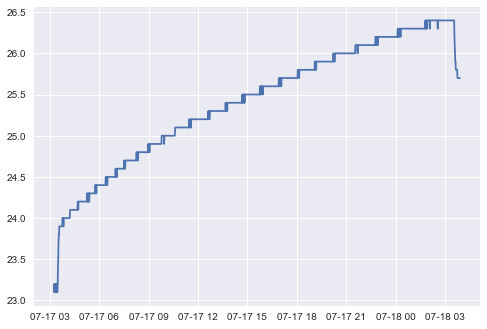

In [ ]:
plt.plot(tlogger_sol["Channel1-Watertank"][3500:4980])
plt.show()

In [ ]:
tlogger_sol["Channel1-Watertank"].index[4980] - tlogger_sol["Channel1-Watertank"].index[3500]

Timedelta('1 days 00:40:03')

# Frequency analysis

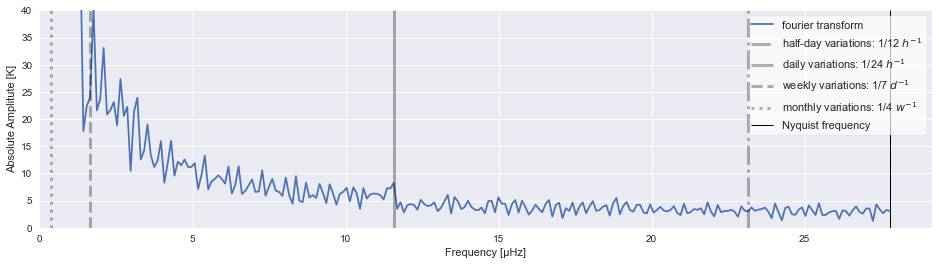

In [ ]:
# frequency spectrum tlogger
data_resample, sampling_time, nyquist_frequqncy = resample_data_func(df_Tlogger_all["Channel1_rolling_mean"])

# Remove date gaps for tlogger, meaning delete points so neighbaring points are atleast similar in time of day
bool_no_data=data_resample.notna() == False
bool_data=data_resample.notna()

# set some more values to false so the data gaps are aligned regarding time
val_to_set_false=[178,179,180,198,199,200,201,278,279]
for val_set_false in val_to_set_false:
    bool_data[val_set_false] = False
data_resample=data_resample[bool_data]

# Check if everything is as expected with this code
diff=data_resample[bool_data].index[1:] - data_resample[bool_data].index[:-1]
diff.sort_values() #diff should be all around 5 h, ignoring full days
# diff.get_loc(diff.sort_values()[-1])

# Fourier Transform
yf, xf = fourier_transform(data_resample, sampling_time)

# Plot transformated signal
vlines=[] #[0.8e-6], [2e-6]
vlines_labels=[] #"about 1/14 days","about 1/6 days"
plot_frequency_spectrum(xf, yf, vlines, vlines_labels, nyquist_frequqncy, ylim=[0,40])

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\watertank_temperature_fourier.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\watertank_temperature_fourier.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\watertank_temperature_fourier.png")
plt.show()

# the logger has some data gaps which influences this spectrum